In [1]:
from toolz import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
# %matplotlib widget


import pathlib
from lenses import lens

from collections import Counter

import re
import nltk
import pymorphy2
import fasttext.util

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
nltk.download('popular')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('tagsets')
nltk.download('stopwords')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\aakomlev\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\aakomlev\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\aakomlev\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\aakomlev\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\aakomlev\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to

True

In [3]:
lmap = compose(list, map)
ltake = compose(list, take)

In [4]:
def map_df_ingredients_element(func, df):
    df = df.copy()
    df['ingredients'] = df['ingredients'].map(lambda v: lmap(func, v))
    return df

In [5]:
data_path = pathlib.Path('data')

## Загружаем датафрейм с данными

In [6]:
df = pd.read_json(data_path.joinpath('ready_dataframe.json'))
df = map_df_ingredients_element(compose(str.lower, str.strip), df)
df

,id,title,course,cuisine,ingredients
0,28195,Банановое мороженое с корицей,Выпечка и десерты,Карибская кухня,"[бананы, лимонный сок, молотая корица, ванильн..."
1,28141,Ананасово-кокосовый шербет,Выпечка и десерты,Карибская кухня,"[сахар, кокосовое молоко, корень имбиря, анана..."
2,27929,"Десерт из манго, клубники и текилы",Выпечка и десерты,Карибская кухня,"[клубника, манго, сахар, тертая цедра лайма, т..."
3,28192,Ананас с соусом из манго и рома,Выпечка и десерты,Карибская кухня,"[манго, темный ром, сок лайма, сахар, тертая ц..."
4,28463,Клубничный соус с текилой,Выпечка и десерты,Карибская кухня,"[клубника, сахарная пудра, сок лайма, текила, ..."
...,...,...,...,...,...
41433,43380,Постный борщ с фасолью,Супы,Украинская кухня,"[белая фасоль, овощной бульон, свекла, картофе..."
41434,80446,Суп энгамат,Супы,Шведская кухня,"[цветная капуста, морковь, картофель, лук-поре..."
41435,136820,Гороховый суп с блинчиками,Супы,Шведская кухня,"[горох, репчатый лук, гвоздика, свиная рулька,..."
41436,18014,Суп из брокколи и кростини с сыром бри,Супы,Шведская кухня,"[оливковое масло, репчатый лук, овощной бульон..."


## Работа с ингридиентами

Удобнее работать с листом листов:

In [7]:
ingredients = list(df['ingredients'])
# TODO !!!!!!!!! Временно берем только первые несколько записей 
ingredients = ingredients 
ingredients[:3]

[['бананы', 'лимонный сок', 'молотая корица', 'ванильное мороженое'],
 ['сахар', 'кокосовое молоко', 'корень имбиря', 'ананас', 'сок лайма'],
 ['клубника',
  'манго',
  'сахар',
  'тертая цедра лайма',
  'текила',
  'сок лайма',
  'апельсиновый ликер']]

### Самые часто встречающиеся слова в ингридиентах

In [8]:
ingredients_counter = Counter()
for lst in ingredients:
    ingredients_counter.update(lst)
# first_ingresients, _ = zip(*ingredients_counter.most_common(10))
# first_ingresients = list(first_ingresients)
# first_ingresients
ingredients_counter.most_common(10)

[('соль', 20427),
 ('куриное яйцо', 11621),
 ('сахар', 10953),
 ('молотый черный перец', 10877),
 ('сливочное масло', 10323),
 ('пшеничная мука', 9950),
 ('чеснок', 9558),
 ('оливковое масло', 7932),
 ('репчатый лук', 7272),
 ('растительное масло', 6456)]

In [9]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize(word):
    return morph.parse(word)[0].normal_form

it = lmap(compose(tuple, nltk.word_tokenize), ingredients_counter)
it = lens.Each().Each().modify(lemmatize)(it)
it[:10]

[('банан',),
 ('лимонный', 'сок'),
 ('молотый', 'корица'),
 ('ванильный', 'мороженое'),
 ('сахар',),
 ('кокосовый', 'молоко'),
 ('корень', 'имбирь'),
 ('ананас',),
 ('сок', 'лайм'),
 ('клубника',)]

### Токенизация

In [10]:
ingredients_tokenized = lens.Each().Each().modify(nltk.word_tokenize)(ingredients)
ingredients_tokenized[:4]

[[['бананы'],
  ['лимонный', 'сок'],
  ['молотая', 'корица'],
  ['ванильное', 'мороженое']],
 [['сахар'],
  ['кокосовое', 'молоко'],
  ['корень', 'имбиря'],
  ['ананас'],
  ['сок', 'лайма']],
 [['клубника'],
  ['манго'],
  ['сахар'],
  ['тертая', 'цедра', 'лайма'],
  ['текила'],
  ['сок', 'лайма'],
  ['апельсиновый', 'ликер']],
 [['манго'],
  ['темный', 'ром'],
  ['сок', 'лайма'],
  ['сахар'],
  ['тертая', 'цедра', 'лайма'],
  ['ананас']]]

### Стоп-слова и фильтрация

In [11]:
stopwords = nltk.corpus.stopwords.words('russian')

In [12]:
rx = re.compile(r'[a-zA-Zа-яА-Я][a-zA-Zа-яА-Я\d\-]*')

In [13]:
ingredients_filtered = (lens
    .Each().Each().modify(
        lambda tokenized: tuple(filter(
            lambda word: word not in stopwords and rx.match(word),
            tokenized))
    )(ingredients_tokenized)
)
ingredients_filtered[:4]

[[('бананы',),
  ('лимонный', 'сок'),
  ('молотая', 'корица'),
  ('ванильное', 'мороженое')],
 [('сахар',),
  ('кокосовое', 'молоко'),
  ('корень', 'имбиря'),
  ('ананас',),
  ('сок', 'лайма')],
 [('клубника',),
  ('манго',),
  ('сахар',),
  ('тертая', 'цедра', 'лайма'),
  ('текила',),
  ('сок', 'лайма'),
  ('апельсиновый', 'ликер')],
 [('манго',),
  ('темный', 'ром'),
  ('сок', 'лайма'),
  ('сахар',),
  ('тертая', 'цедра', 'лайма'),
  ('ананас',)]]

### Лемматизация

In [14]:
ingredients_lemmatized = lens.Each().Each().Each().modify(lemmatize)(ingredients_filtered)
ingredients_lemmatized[:4]

[[('банан',),
  ('лимонный', 'сок'),
  ('молотый', 'корица'),
  ('ванильный', 'мороженое')],
 [('сахар',),
  ('кокосовый', 'молоко'),
  ('корень', 'имбирь'),
  ('ананас',),
  ('сок', 'лайм')],
 [('клубника',),
  ('манго',),
  ('сахар',),
  ('тёртый', 'цедра', 'лайм'),
  ('текила',),
  ('сок', 'лайм'),
  ('апельсиновый', 'ликёр')],
 [('манго',),
  ('тёмный', 'ром'),
  ('сок', 'лайм'),
  ('сахар',),
  ('тёртый', 'цедра', 'лайм'),
  ('ананас',)]]

In [50]:
#ОЧЕНЬ ДОЛГО
all_words_lemmatized = Counter(lens.Each().Each().Each().collect()(ingredients_lemmatized))

all_words_lemmatized_list = list(all_words_lemmatized)

#Добавил UNK и PAD
all_words_lemmatized_list = ['PAD', 'UNK']+all_words_lemmatized_list
all_words_lemmatized_list.sort()
all_words_lemmatized_list[:10]
# dict(all_words.items())

['PAD',
 'UNK',
 'añejo',
 'baby',
 'baileys',
 'bambino',
 'bean',
 'biogourmet',
 'biscoff',
 'blue',
 'bounty',
 'brugal',
 'bull',
 'calibrata',
 'calve',
 'campbell',
 'captain',
 'cassis',
 'cheerios',
 'chili',
 'clasico',
 'corona',
 'crisp',
 'curacao',
 'cмородиновый',
 'cыр',
 'daniel',
 'delikate',
 'dr.oetker',
 'earl',
 'everclear',
 'extra',
 'finn',
 'frank',
 'fresca',
 'gatorade',
 'gillardeau',
 'grey',
 'guinness',
 'heinz',
 'hendrick',
 'herbamare',
 'hochland',
 'hp',
 'ideal',
 'irca',
 'jack',
 'jameson',
 'kewpie',
 'king',
 'kitchen',
 'kitkat',
 'knorr',
 'kriek',
 'lambic',
 'le',
 'lindemans',
 'm',
 'maltesers',
 'men',
 'mix',
 'morgan',
 'mort',
 'nutella®',
 'olivotto',
 'oreo',
 'party',
 'pasta',
 'peychaud',
 'powder',
 'red',
 'rib',
 'roule',
 's',
 'sablé',
 'sambar',
 'semola',
 'spare',
 'spiced',
 'spicy',
 'subite',
 'suze',
 'tabasco®',
 'traditional',
 'unagrande',
 'valsugana',
 'virgin',
 'vita',
 'witte',
 'würze',
 'абрикос',
 'абрикосо

In [16]:
#ДОЛГО + много оперативки
fasttext.util.download_model('ru', if_exists='ignore')

'cc.ru.300.bin'

In [106]:
ft = fasttext.load_model('cc.ru.300.bin')
fasttext.util.reduce_model(ft, 50)
dim = ft.get_dimension()
dim

50

### Получаем векторы для слов 

In [107]:
word_embeddings_dict = {}
for word in all_words_lemmatized_list:
    if word  == 'PAD':
        word_embeddings_dict[word] = np.concatenate((np.zeros(dim),[1, 0]))
    elif word  == 'UNK':
        word_embeddings_dict[word] = np.concatenate((np.zeros(dim),[0, 1]))
    else:
        word_embeddings_dict[word] = np.concatenate((ft.get_word_vector(word), [0, 0]))

In [108]:
first(word_embeddings_dict.items())
# np.concatenate((ft.get_word_vector(word), [0, 0])).shape

('PAD',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.]))

Расширяем разметрости для PAD и UNK

In [109]:
dim += 2
# dim = 102

In [110]:
# Освободаем оперативку
del ft

In [111]:
# word_num = [(word, i) for i, word in enumerate(words)]
# word_num[:10]

### Векторы для ингредиентов

In [112]:
all_ingredients_list =  list(set(lens.Each().Each().collect()(ingredients_lemmatized)))
#Добавил UNK и PAD
all_ingredients_list = [('PAD',), ('UNK',)]+all_ingredients_list
all_ingredients_list 
ingredients_numbering_dict = {ingredient: i for i, ingredient in enumerate(all_ingredients_list)}
ltake(6, ingredients_numbering_dict.items())

[(('PAD',), 0),
 (('UNK',), 1),
 (('устрица', 'gillardeau'), 2),
 (('малосольный', 'огурец'), 3),
 (('свиной', 'копчёный', 'рулька'), 4),
 (('измельчить', 'жареный', 'фундук'), 5)]

Для получения вектора для ингридиента просто суммируем векторы для каждого слова в этом ингридиенте:

In [113]:
ingredients_embeddings_dict = {}
for ingr in all_ingredients_list:
    ingredients_embeddings_dict[ingr] = np.zeros(dim)
    for word in ingr:
#         ingredients_embeddings_dict[ingr] += ft.get_word_vector(word) 
        ingredients_embeddings_dict[ingr] += word_embeddings_dict[word] # Должно заработать, когда 
                                                                         # ингредиенты будут лемматизированны
ltake(1, ingredients_embeddings_dict.items())[0]


(('PAD',),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.]))

Наконец, для каждого рецепта возьмем его векторизацию как сумму векторов его ингридиентов

In [114]:
ingredients_by_recipe_embedding = [
    sum(ingredients_embeddings_dict[ingredient]
        for ingredient in ingredient_list) 
    for ingredient_list in ingredients_lemmatized
]
len(ingredients_by_recipe_embedding)

41438

## Данные для нейросети

Всевозможные метки (course):

In [115]:
all_courses = {name: num for num, name in enumerate(df['course'][~df['course'].duplicated()])}
all_courses

{'Выпечка и десерты': 0,
 'Завтраки': 1,
 'Закуски': 2,
 'Напитки': 3,
 'Основные блюда': 4,
 'Паста и пицца': 5,
 'Салаты': 6,
 'Соусы и маринады': 7,
 'Супы': 8}

In [116]:
df_for_learning = pd.DataFrame(data={
    'id': df['id'],
    'ingredient_embedding': ingredients_by_recipe_embedding,
    'course_mark': [all_courses[course] for course in df['course']]
})
df_for_learning

,id,ingredient_embedding,course_mark
0,28195,"[0.529789550229907, 0.3361273128539324, -0.270...",0
1,28141,"[0.32061362639069557, 0.49827011598972604, -0....",0
2,27929,"[1.038355067372322, 0.4399354930501431, -0.348...",0
3,28192,"[1.0121009461581707, 0.6283394705387764, -0.37...",0
4,28463,"[0.6364698223769665, 0.1647892117034644, -0.29...",0
...,...,...,...
41433,43380,"[1.2473316863179207, 0.8848994169384241, -0.62...",8
41434,80446,"[1.2712522372603416, 0.5677279131487012, -0.42...",8
41435,136820,"[1.2513769371435046, 0.7746094663161784, -0.04...",8
41436,18014,"[1.3760087881237268, 0.718187878606841, -0.361...",8


In [117]:
# tf.keras.preprocessing.text.one_hot(all_courses, len(all_courses))

## Подготовка BoE

In [ ]:
data = np.array(ingredients_by_recipe_embedding)
labels = to_categorical(np.array(df_for_learning['course_mark']), num_classes=len(all_courses))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

## Обучение BoE

In [ ]:
sequence_input = layers.Input(shape=(dim,), dtype='int32')
x = layers.Dense(64, activation='relu')(sequence_input)
x = layers.Dense(16, activation='relu')(x)
preds = layers.Dense(len(all_courses), activation='softmax')(x)

model = keras.Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
EPOCHS = 20
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=EPOCHS, batch_size=128)

In [ ]:
loss = H.history['loss'] 
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Подготовка к CNN

In [118]:
data = lens.Each().Each().modify(lambda x: ingredients_numbering_dict[x])(ingredients_lemmatized)

In [119]:
data[:2]

[[1421, 1297, 204, 2187], [1124, 1323, 2338, 3615, 3469]]

In [120]:
data = pad_sequences(data, padding='post', value=0)
labels = to_categorical(np.array(df_for_learning['course_mark']), num_classes=len(all_courses))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [121]:
max_length = len(data[0])
max_length

40

In [122]:
#Эта матрица будет использоваться для слоя Embedding в keras
ingredients_embeddings_matrix = np.zeros((len(all_ingredients_list), dim))
ingredients_embeddings_matrix.shape
for ingr in all_ingredients_list:
    ingredients_embeddings_matrix[ingredients_numbering_dict[ingr]] = ingredients_embeddings_dict[ingr]
ingredients_embeddings_matrix.shape

(4406, 52)

## Обучение CNN

In [123]:
embedding_layer = layers.Embedding(len(ingredients_embeddings_dict),
                            dim,
                            weights=[ingredients_embeddings_matrix],
                            input_length=max_length,
                            trainable=True)
# trainable=True позволит до обучаться эмбеддингам на нашем датасете

In [124]:
sequence_input = layers.Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = layers.Conv1D(64, 2, activation='relu')(embedded_sequences)
x = layers.GlobalMaxPool1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
preds = layers.Dense(len(all_courses), activation='softmax')(x)

model = keras.Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [125]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 40, 52)            229112    
                                                                 
 conv1d_7 (Conv1D)           (None, 39, 64)            6720      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                           

In [126]:
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=128)

Epoch 1/20
259/259 [==============================] - 3s 10ms/step - loss: 1.4732 - accuracy: 0.5013 - val_loss: 1.2160 - val_accuracy: 0.5761
Epoch 2/20
259/259 [==============================] - 2s 8ms/step - loss: 1.0865 - accuracy: 0.6170 - val_loss: 0.9963 - val_accuracy: 0.6398
Epoch 3/20
259/259 [==============================] - 3s 10ms/step - loss: 0.9067 - accuracy: 0.6809 - val_loss: 0.9204 - val_accuracy: 0.6702
Epoch 4/20
259/259 [==============================] - 2s 9ms/step - loss: 0.8152 - accuracy: 0.7127 - val_loss: 0.8665 - val_accuracy: 0.6918
Epoch 5/20
259/259 [==============================] - 2s 9ms/step - loss: 0.7544 - accuracy: 0.7376 - val_loss: 0.8353 - val_accuracy: 0.7052
Epoch 6/20
259/259 [==============================] - 3s 10ms/step - loss: 0.7074 - accuracy: 0.7543 - val_loss: 0.8158 - val_accuracy: 0.7141
Epoch 7/20
259/259 [==============================] - 2s 9ms/step - loss: 0.6687 - accuracy: 0.7685 - val_loss: 0.8111 - val_accuracy: 0.7136
Epo

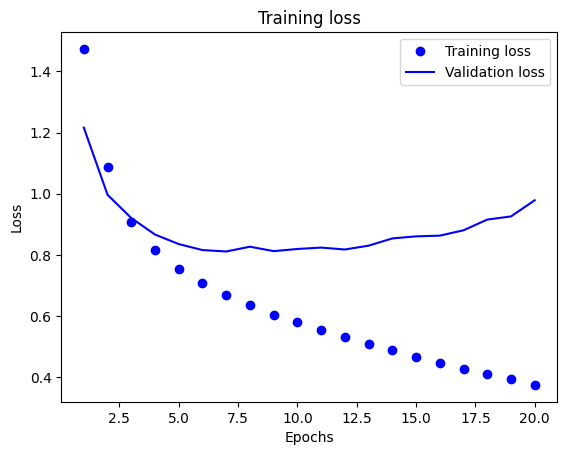

In [127]:
loss = H.history['loss'] 
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

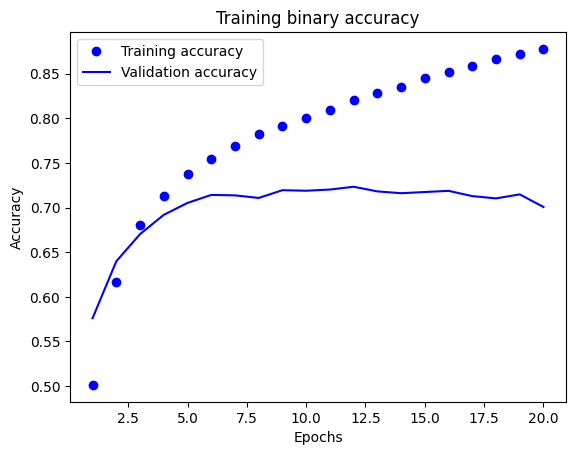

In [128]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Прочее:

In [45]:
it = df.groupby('cuisine').count()
it.sort_values('title', ascending=False).head(30)

,id,title,course,ingredients
cuisine,,,,
Европейская кухня,11699,11699,11699,11699
Русская кухня,7111,7111,7111,7111
Итальянская кухня,4943,4943,4943,4943
Французская кухня,3055,3055,3055,3055
Американская кухня,2192,2192,2192,2192
Авторская кухня,1822,1822,1822,1822
Китайская кухня,840,840,840,840
Греческая кухня,640,640,640,640
Мексиканская кухня,583,583,583,583


In [46]:
a = ft.get_word_vector('кокосовый')-ft.get_word_vector('кокосовое')+ft.get_word_vector('кремовое')-ft.get_word_vector('кремовый')
a@a

NameError: name 'ft' is not defined